# REINFORCE

---

In this notebook, we will train REINFORCE with OpenAI Gym's Cartpole environment.

### 1. Import the Necessary Packages

In [1]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
tf.random.set_seed(0)

### 2. Define the Architecture of the Policy

In [2]:
env = gym.make('CartPole-v0')
env.seed(0)
print('observation space:', env.observation_space)
print('action space:', env.action_space)

class Network(tf.keras.Model):
    def __init__(self, h_size=16, a_size=2):
        super(Network, self).__init__()
        self.fc1 = tf.keras.layers.Dense(h_size)
        self.fc2 = tf.keras.layers.Dense(a_size)
    
    def call(self, x):
        x = tf.nn.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class Policy:
    def __init__(self, s_size=4, h_size=16, a_size=2):
        self.network = Network(h_size, a_size)
    
    @tf.function
    def act(self, state):
        policy_logits = self.network(state)
        sample_action = tf.squeeze(tf.random.categorical(policy_logits, 1), 1)
        return sample_action
    
    def neglogprobs(self, policy_logits, actions):  
        return tf.nn.sparse_softmax_cross_entropy_with_logits(labels=actions,logits=policy_logits)
    
    
    
    @tf.function(input_signature=[tf.TensorSpec(shape=(None,None), dtype=tf.float32),
                                  tf.TensorSpec(shape=None, dtype=tf.int32),
                                  tf.TensorSpec(shape=None, dtype=tf.float32)],)
    def optimize(self, states, actions, adv):
        with tf.GradientTape() as tape:
            logits = self.network(states)
            neglogprobs = self.neglogprobs(logits, actions)
            loss = tf.reduce_sum(neglogprobs * adv)
            
        grads = tape.gradient(loss, self.network.trainable_variables)
        optimizer.apply_gradients(zip(grads, self.network.trainable_variables))

observation space: Box(4,)
action space: Discrete(2)


In [3]:
def sample_trajectory(env, policy, max_t):
    states = []
    rewards = []
    actions = []
    state = env.reset()
    for t in range(max_t):
        action = policy.act(np.array(state)[None]).numpy()[0]
        states.append(state)
        actions.append(action)
        state, reward, done, _ = env.step(action)
        rewards.append(reward)
        if done:
            break 
            
    return np.array(states, dtype=np.float32), np.array(actions, dtype=np.int32), np.array(rewards, dtype=np.float32)

### 3. Train the Agent with REINFORCE

In [4]:
policy = Policy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)

def reinforce(n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        
        states, actions, rewards = sample_trajectory(env, policy, max_t)
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = (sum([a*b for a,b in zip(discounts, rewards)])).astype(np.float32)
        
        states = tf.convert_to_tensor(states)
        actions = tf.convert_to_tensor(actions)
        tot_reward = tf.convert_to_tensor(R)
        
        policy.optimize(states, actions, tot_reward)
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
        
    return scores
    
scores = reinforce()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Episode 100	Average Score: 37.15
Episode 200	Average Score: 50.36
Episode 300	Average Score: 97.90
Episode 400	Average Score: 135.65
Episode 500	Average Score: 152.88
Environment solved in 459 episodes!	Average Score: 195.32


### 4. Plot the Scores

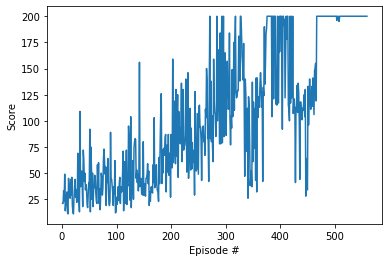

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch a Smart Agent!

In [6]:
env = gym.make('CartPole-v0')
env = gym.wrappers.Monitor(env, 'videos/', force=True)
state = env.reset()
for t in range(1000):
    action = policy.act(np.array(state)[None]).numpy()[0]
    #env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()